In [22]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

%load_ext sql
conn = duckdb.connect()
%sql duckdb:///:memory:
%sql conn --alias duckdb

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [23]:
%%sql
CREATE TABLE Riders             AS FROM "../data/riders.csv";
CREATE TABLE RiderTeams         AS FROM "../data/rider_teams.csv";
CREATE TABLE Managers           AS FROM "../data/managers.csv";
CREATE TABLE ManagerTeams       AS FROM "../data/manager_teams.csv";
CREATE TABLE ManagerTeamsCheapo AS FROM "../data/manager_cheapo_teams.csv";
CREATE TABLE PointsSystem       AS FROM "../data/points_system.csv";
CREATE TABLE Races              AS FROM "../data/races.csv";
CREATE TABLE Results_2023       AS FROM "../data/results/results_2023_full.csv";
CREATE TABLE Results_2024       AS FROM "../data/results/results_2024_full.csv";
CREATE TABLE Results_2025       AS FROM "../data/results/results_2025_full.csv";
CREATE TABLE CheapoBans         AS FROM "../data/cheapo_bans.csv";

,Count
0,14


In [24]:
%%sql
CREATE OR REPLACE TABLE RaceResultsPoints AS
SELECT
     results.Race
    ,races.RaceName
    ,races.RaceCategory
    ,results.Stage_ID
    ,COALESCE(results.Stage_Date, races.RaceStart) AS Stage_Date
    ,results.Stage_Type
    ,CASE WHEN results.Stage_ID <> 'gc' AND (results.Stage_Type <> 'TTT' OR results.Stage_Type IS NULL) THEN 1 ELSE 0 END AS Løbsdage
    ,results.Rider AS RiderName_PCS
    ,riders.RiderName_Zweeler
    ,riders.RiderPrice
    ,riders.RiderTeam
    ,CASE WHEN cbans.RiderName IS NULL AND riders.RiderPrice <= 2.5 THEN 'Ja' ELSE '' END AS Cheapo
    ,results.Rank
    ,points.RacePoints AS Points
    ,CASE WHEN races.RaceName = 'Tour Down Under' THEN NULL Else points.RacePoints END AS CheapoPoints
FROM Riders riders
LEFT JOIN Results_2025 results ON results.Rider = riders.RiderName_PCS
LEFT JOIN Races races ON races.RaceName_PCS = results.Race
LEFT JOIN CheapoBans cbans ON cbans.RiderName = riders.RiderName_Zweeler
LEFT JOIN PointsSystem points ON 1 = 1
    AND (results.Stage_Type IS NULL OR results.Stage_Type <> 'TTT')
    AND points.RaceRank = TRY_CAST(results.Rank AS INTEGER) 
    AND CASE WHEN results.Stage_ID LIKE '%stage%' THEN REPLACE(races.RaceCategory, 'Tour', 'Stage') ELSE races.RaceCategory END = points.RaceCategory;

,Count
0,25784


In [25]:
%%sql
df <<
WITH Datoer AS
(
    SELECT DISTINCT Stage_Date
    FROM RaceResultsPoints
    WHERE 1 = 1
        # AND Points > 0
), RankedDatoer AS
(
    SELECT Stage_Date, ROW_NUMBER() OVER(ORDER BY Stage_Date ASC) AS RN
    FROM Datoer
), RaceResultsManagers AS
(
    SELECT 
         results.Stage_Date
        ,results.Points
        ,teams.ManagerName
    FROM RaceResultsPoints results
    INNER JOIN ManagerTeams teams ON teams.RiderName = results.RiderName_Zweeler
    INNER JOIN Datoer dd ON dd.Stage_Date = results.Stage_Date
    WHERE 1 = 1
        AND Points > 0
)
SELECT 
     src.RN AS Løbsdag
    ,src.Stage_Date
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Chrelle'), 0) AS INTEGER) AS Chrelle
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Kenk'), 0) AS INTEGER) AS Kenk
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Knak'), 0) AS INTEGER) AS Knak
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Matti'), 0) AS INTEGER) AS Matti
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Okholm'), 0) AS INTEGER) AS Okholm
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Jappo'), 0) AS INTEGER) AS Jappo
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Hustlersen'), 0) AS INTEGER) AS Hustlersen
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Jarma'), 0) AS INTEGER) AS Jarma
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Visti'), 0) AS INTEGER) AS Visti
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Tommy'), 0) AS INTEGER) AS Tommy
FROM RankedDatoer src
ORDER BY RN;

In [26]:
df

,Løbsdag,Stage_Date,Chrelle,Kenk,Knak,Matti,Okholm,Jappo,Hustlersen,Jarma,Visti,Tommy
0,1,2025-01-21,47,36,10,2,2,2,60,0,10,41
1,2,2025-01-22,84,62,28,14,14,14,109,0,28,100
2,3,2025-01-23,116,104,42,28,31,44,145,8,28,114
3,4,2025-01-24,126,136,60,38,41,54,171,8,46,142
4,5,2025-01-25,156,161,60,38,67,70,230,8,46,142
...,...,...,...,...,...,...,...,...,...,...,...,...
142,143,2025-07-24,7123,6144,5964,5558,6214,6445,5373,5547,5929,5803
143,144,2025-07-25,7194,6199,6037,5610,6321,6506,5446,5602,6006,5864
144,145,2025-07-26,7212,6199,6061,5610,6351,6506,5446,5620,6006,5865
145,146,2025-07-27,7710,6588,6557,5897,7007,6878,6005,6024,6467,6259


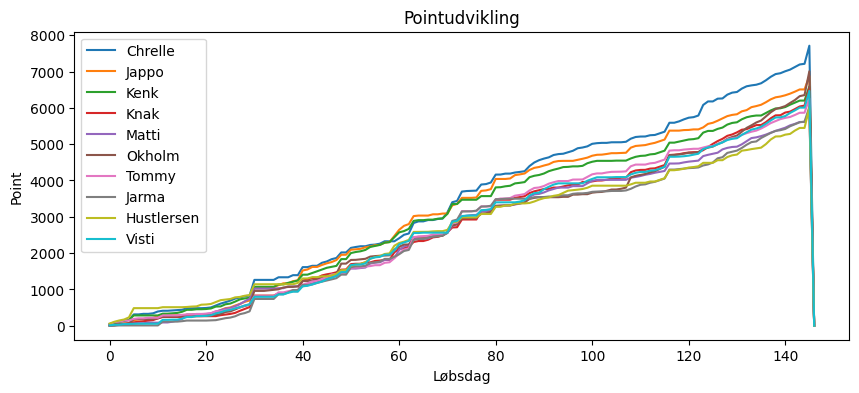

In [27]:
plt.figure(figsize=(10, 4))  # Wider chart: 12 units wide, 4 units tall

#plot individual lines
plt.plot(df['Chrelle'], label = 'Chrelle')
plt.plot(df['Jappo'], label = 'Jappo')
plt.plot(df['Kenk'], label = 'Kenk')
plt.plot(df['Knak'], label = 'Knak')
plt.plot(df['Matti'], label = 'Matti')
plt.plot(df['Okholm'], label = 'Okholm')
plt.plot(df['Tommy'], label = 'Tommy')
plt.plot(df['Jarma'], label = 'Jarma')
plt.plot(df['Hustlersen'], label = 'Hustlersen')
plt.plot(df['Visti'], label = 'Visti')

plt.title("Pointudvikling")
plt.xlabel("Løbsdag")
plt.ylabel("Point")

plt.legend()
plt.show()



In [28]:
%%sql
    SELECT DISTINCT Stage_Date
    FROM RaceResultsPoints
    WHERE 1 = 1
        AND Points > 0
        AND Stage_Date >= '2025-05-01'

,Stage_Date
0,2025-05-15
1,2025-05-02
2,2025-05-03
3,2025-05-24
4,2025-05-29
...,...
58,2025-07-14
59,2025-07-17
60,2025-07-18
61,2025-07-24
